Подавляющее большинство методов классификации и регрессии сформулированы в терминах евклидовых или метрических пространств, то есть подразумевают представление данных в виде вещественных векторов одинаковой размерности. В реальных данных, однако, не так редки категориальные атрибуты, принимающие дискретные значения, такие как да/нет или январь/февраль/.../декабрь. В ходе этого занятия мы научимся работать с такими данными, в частности с помощью линейных моделей.

In [48]:
import pandas as pd
import numpy as np
import sklearn.linear_model
import sklearn.model_selection
import sklearn.metrics
import sklearn.preprocessing
import sklearn.feature_extraction

%matplotlib inline

import matplotlib.pyplot as plt
from pprint import pformat
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [50]:
df = pd.read_csv('bank.csv')
for col in ['deposit']:
    df[col] = np.where(df[col] == 'yes', 1, 0)
labels = df['deposit']
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,1


Нетрудно заметить, что достаточно много признаков в этом наборе данных не представлены числами. В таком виде данные еще нам не подходят - мы не сможем применять подавляющее большинство доступных нам методов.

Чтобы найти решение, давайте рассмотрим атрибут education:

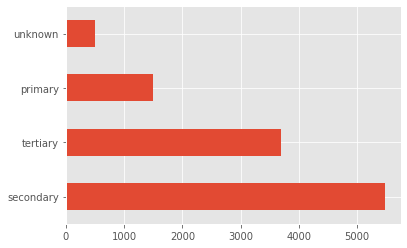

In [51]:
df['education'].value_counts().plot.barh();

Естественным решением такой проблемы было бы однозначное отображение каждого значения в уникальное число. К примеру, мы могли бы преобразовать university.degree в 0, а basic.9y в 1. Эту простую операцию приходится делать часто, поэтому в модуле preprocessing библиотеки sklearn именно для этой задачи реализован класс LabelEncoder:

In [52]:
label_encoder = sklearn.preprocessing.LabelEncoder()

Метод fit этого класса находит все уникальные значения и строит таблицу для соответствия каждой категории некоторому числу, а метод transform непосредственно преобразует значения в числа. После fit у label_encoder будет доступно поле classes, содержащее все уникальные значения. Пронумеруем их, чтобы убедиться, что преобразование выполнено верно.

{0: 'primary', 1: 'secondary', 2: 'tertiary', 3: 'unknown'}


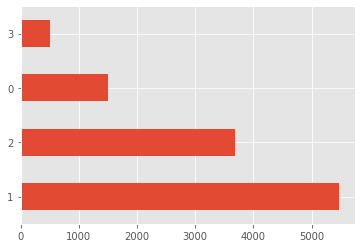

In [53]:
mapped_education = pd.Series(label_encoder.fit_transform(df['education']))
mapped_education.value_counts().plot.barh()
print(dict(enumerate(label_encoder.classes_)))

Что произойдет, если у нас появятся данные с другими категориями?

In [54]:
try:
    label_encoder.transform(df['education'].replace('secondary', 'secondary'))
except Exception as e:
    print('Error:', e)

In [42]:
df['education'] = mapped_education
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,1,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,1,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,1,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,1,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,2,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


Продолжим преобразование для всех столбцов, имеющих тип object - именно этот тип задается в pandas для таких данных.

In [55]:
categorical_columns = df.columns[df.dtypes == 'object'].union(['education'])
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,0,1,1,0,2343,1,0,2,5,8,1042,1,-1,0,3,1
1,56,0,1,1,0,45,0,0,2,5,8,1467,1,-1,0,3,1
2,41,9,1,1,0,1270,1,0,2,5,8,1389,1,-1,0,3,1
3,55,7,1,1,0,2476,1,0,2,5,8,579,1,-1,0,3,1
4,54,0,1,2,0,184,0,0,2,5,8,673,2,-1,0,3,1


Основная проблема такого представления заключается в том, что числовой код создал евклидово представление для данных.

К примеру, нами неявным образом была введена алгебра над значениями работы - мы можем вычесть работу клиента 1 из работы клиента 2:

In [56]:
df.loc[1].job - df.loc[2].job

-9

Конечно же, эта операция не имеет никакого смысла. Но именно на этом основаны метрики близости объектов, что делает бессмысленным применение метода ближайшего соседа на данных в таком виде. Аналогичным образом, никакого смысла не будет иметь применение линейных моделей. Убедимся в этом:

In [57]:
def logistic_regression_accuracy_on(dataframe, labels):
    features = dataframe.as_matrix()
    train_features, test_features, train_labels, test_labels = \
        sklearn.model_selection.train_test_split(features, labels)

    lr = sklearn.linear_model.LogisticRegression()
    lr.fit(train_features, train_labels)
    return sklearn.metrics.classification_report(test_labels, lr.predict(test_features))

print(logistic_regression_accuracy_on(df[categorical_columns], labels))

              precision    recall  f1-score   support

           0       0.67      0.65      0.66      1489
           1       0.61      0.63      0.62      1302

    accuracy                           0.64      2791
   macro avg       0.64      0.64      0.64      2791
weighted avg       0.64      0.64      0.64      2791



Для того, чтобы мы смогли применять линейные модели на таких данных нам необходим другой метод, который называется one-hot encoding.

Предположим, что некоторый признак может принимать 10 разных значений. В этом случае one hot encoding подразумевает создание 10 признаков, все из которых равны нулю за исключением одного. На позицию, соответствующую численному значению признака мы помещаем 1:

In [58]:
one_hot_example = pd.DataFrame([{i: 0 for i in range(10)}])
one_hot_example.loc[0, 6] = 1
one_hot_example

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,1,0,0,0


Эта техника реализована в sklearn в классе OneHotEncoder. По умолчанию OneHotEncoder преобразует данные в разреженную матрицу, чтобы не расходовать память на хранение многочисленных нулей. Однако в этом примере размер данных не является для нас проблемой, поэтому мы будем использовать "плотное" представление.

In [59]:
onehot_encoder = sklearn.preprocessing.OneHotEncoder(sparse=False)

Преобразуем категориальные столбцы с помощью OneHotEncoder:

In [60]:
encoded_categorical_columns = pd.DataFrame(onehot_encoder.fit_transform(df[categorical_columns]))
encoded_categorical_columns.head()

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [61]:
print(logistic_regression_accuracy_on(encoded_categorical_columns, labels))

              precision    recall  f1-score   support

           0       0.67      0.80      0.73      1467
           1       0.72      0.57      0.63      1324

    accuracy                           0.69      2791
   macro avg       0.69      0.68      0.68      2791
weighted avg       0.69      0.69      0.68      2791



Реальные данные могут оказаться гораздо более динамичными и мы не всегда можем рассчитывать, что категориальные признаки не будут принимать новых значений. Все это сильно затрудняет использование уже обученных моделей на новых данных. Кроме того, LabelEncoder подразумевает предварительный анализ всей выборки и хранение построенных отображений в памяти, что затрудняет работу в режиме больших данных.

Для решения этих проблем существует более простой подход к векторизации категориальных признаков, основанный на хэшировании, известный как hashing trick.

Хэш-функции могут помочь нам в задаче поиска уникальных кодов для различных значений атрибутов, к примеру:

In [62]:
for s in ('university.degree', 'high.school', 'illiterate'):
    print(s, '->', hash(s))

university.degree -> 5600062225469783867
high.school -> 1306607668633271715
illiterate -> -5302391569387139160


Представим, что у нас в выборке есть холостой студент, которому позвонили в понедельник, тогда его вектор признаков будет сформирован аналогично one-hot encoding, но в едином пространстве фиксированного размера для всех признаков:

In [64]:
hash_space = 25
for s in ('university.degree', 'high.school', 'illiterate'):
    print(s, '->', hash(s) % hash_space)

university.degree -> 17
high.school -> 15
illiterate -> 15


In [65]:
hashing_example = pd.DataFrame([{i: 0.0 for i in range(hash_space)}])
for s in ('job=student', 'marital=single', 'day_of_week=mon'):
    print(s, '->', hash(s) % hash_space)
    hashing_example.loc[0, hash(s) % hash_space] = 1
hashing_example

job=student -> 17
marital=single -> 12
day_of_week=mon -> 1


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Стоит обратить внимание, что в этом примере хэшировались не только значения атрибутов, а пары название атрибута + значение атрибута. Это необходимо, чтобы разделить одинаковые значения разных атрибутов между собой, к примеру:

In [66]:
assert hash('no') == hash('no')
assert hash('housing=no') != hash('loan=no')

Может ли произойти коллизия хэш-функции, то есть совпадение кодов для двух разных значений? Нетрудно доказать, что при достаточном размере пространства хэширования это происходит редко, но даже в тех случаях, когда это происходит, это не будет приводить к существенному ухудшению качества классификации или регрессии.

В следующей части занятия мы будем применять подход на основе хэширования для работы с категориальными данными.